**Assignment 1: Generating "Human-Like Rhythms from a given corpus**

**Part 1: Preprocessing - Parsing the dataset**

**Goal:** Parse the abc music files to only get the elements related to the rhythm. We will use music21 to obtain, from each piece's abc file, a list of bars with each bar containing the beats on which a note appears. Then, we will create a Dataframe of all the pieces encoded in list form, which we can split to use as a training set and a test set.

In [63]:
# !pip install music21
# !pip install textract
# !pip install networkx

import pandas as pd
import numpy as np
import ast
import music21
import os
import textract
import pathlib
from collections import defaultdict
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# Function that, from an abc file, gets the beat distribution of every bar of the piece
# Returns an array (piece) of arrays (bars)
def extractBeatArray(path):

    # getting the parsable score
    sample = music21.converter.parse(path)
    part = sample.parts[0]
    notes = part.recurse().notes
    length_in_bars = int(sample.duration.quarterLength/sample.getTimeSignatures()[0].numerator) 
    # should be numerator*(denominator/4), but here denominator is already 4 since all pieces are in 3/4
    
    bars = []

    # iteratively adding every beat of every bar. Each bar is a list and the piece is a list of bars i.e. a list of lists
    for i in range(0, length_in_bars):
        if part.measure(i) is not None:
            notes = part.measure(i).notes
            beats = []
            for n in notes:
                beats.append(n.beat)
                    
        bars.append(beats)
        i += 1

    return bars

In [65]:
# Parsing the dataset with the above function

data = pd.DataFrame(columns=['piece', 'notes'])

path = "./abc/_1814_698087.abc"

directory = './abc'

pieces = 0 # check every piece in the directory (599) is encoded

for name in os.listdir(directory):
    pieces += 1
    path = directory + '/' + name 
    bars = []
    try:
        bars = extractBeatArray(path)
    except:
        bars = []

    if (bars != []): # not adding unparsed pieces to dataframe
        data.loc[len(data)] = [path, bars]


print(f"{pieces} pieces were analysed.")    

print(f"{len(data)} pieces were correctly parsed.")

599 pieces were analysed.
585 pieces were correctly parsed.


In [66]:
# List of pieces that throw an exception (9)
exceptions = ['./abc/Näckapolska_efter_Anders_Bredal_c55b3d.abc', './abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_no_84_f2a90d.abc',
'./abc/Polonäs_a39d56.abc', './abc/Polonäs_efter_Pehr_Andersson_Bild_30_nr_90_d06dcf.abc', './abc/Slängpolska_efter_Olof_Larsson_2f914f.abc',
'./abc/_Polonesse_in_G_Moll_no_1_ur_Anders_Larssons_notbok_61aa5e.abc', './abc/_Polonesse_in_G_Måll_no_2_769438.abc', 
'./abc/_Polonäs_sexdregasamlingen_del_2_nr_70_1b9662.abc', './abc/_Polska_Kringellåt_efter_Snickar_Erik_985b63.abc']

# Testing: 14 pieces are registered as note-less, for some reason. The 9 ones that threw an exception + 5 unknown others. 
# We choose to omit them from the dataset.

In [67]:
# Function that maps the beat distribution of a bar to a series of numbers between 1 and 12 (position of each sixteenth-note in the bar)
def map_beats(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for x in bar:
            bar_mapped.append(int(4*(x-1)+1))
        notes_mapped.append(bar_mapped)
    return notes_mapped

In [68]:
# Function that maps a series of numbers between 1 and 12 (position of each sixteenth-note in the bar) to a music21 beat distribution
def map_beats_reverse(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for y in bar:
            bar_mapped.append((y+3)/4)
        notes_mapped.append(bar_mapped)
    return notes_mapped

In [69]:
# Testing the function
example_notes = data[data['piece'] == './abc/_1814_698087.abc']['notes'].tolist()[0]
# when we retrieve a specific piece and convert to list it wraps the piece's array in another array for some reason, hence the [0]
# but when doing iterrows we don't have that problem
print(example_notes)
map_12 = map_beats(example_notes)
print(map_12)
print(map_beats_reverse(map_12))

[[1.0, 1.5, 2.0, 3.0], [1.0, 1.5, 2.0, 3.0], [1.0, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 2.0, 3.0], [1.0, 1.5, 2.0, 3.0], [1.0, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 2.0], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 2.0]]
[[1, 3, 5, 9], [1, 3, 5, 9], [1, 4, 5, 7, 9, 11], [1, 3, 4, 5, 7, 9, 11], [1, 3, 5, 9], [1, 3, 5, 9], [1, 4, 5, 7, 9, 11], [1, 3, 5], [1, 3, 5, 7, 9, 11], [1, 3, 5, 7, 9, 11], [1, 4, 5, 7, 9, 11], [1, 5, 6, 7, 8, 9, 11], [1, 3, 5, 7, 9, 11], [1, 3, 5, 7, 9, 11], [1, 4, 5, 7, 9, 11], [1, 5]]
[[1.0, 1.5, 2.0, 3.0], [1.0, 1.5, 2.0, 3.0], [1.0, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 2.0, 3.0], [1.0, 1.5, 2.0, 3.0], [1.0, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 2.0], [1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 

In [70]:
# Using the mapping function on every piece
data_mapped = data.copy()

for _, d in data_mapped.iterrows():
    d['notes'] = map_beats(d['notes'])

print("Done")

data_mapped.head() # our dataframe for the model!

Done


,piece,notes
0,./abc/1b651a94a8f8680da3cef1e60705194d.abc,"[[1, 3, 5, 6, 7, 8, 9, 11], [1, 3, 5, 6, 7, 8,..."
1,./abc/3679c385a618c89f00d159f418022b39.abc,"[[1, 3, 4, 5, 7, 8, 9, 11], [1, 4, 5, 6, 7, 8,..."
2,./abc/60ae81952628613e03d563b0dae8bbc2.abc,"[[1, 4, 5, 7, 9, 10, 11, 12], [1, 3, 5, 9, 11]]"
3,./abc/6a7d307d1f0712090e4043a6b4637efa.abc,"[[1, 5, 9], [1, 1, 3, 4, 5, 7, 9, 11], [1, 4, ..."
4,./abc/8c6965e3c831e8cb769e578423c12d1e.abc,"[[1, 5, 7, 8, 9], [1, 3, 4, 5, 6, 7, 8, 9, 10,..."


In [71]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(data_mapped) # split 75% train 25% test

print(len(x_train))
print(len(x_test))

438
147


In [72]:
# Writing train and test to csv
x_train.to_csv("train.csv", index=False)
x_test.to_csv("test.csv", index=False)

**Part 2: The Random Model**

**Goal:** generate random 8-bar rhythms. The only constraint is the the minimal note duration is a sixteenth note.

In [73]:
import random

random.seed(1113)

In [74]:
# function to fill a bar with random notes
def random_bar():
    # first = True
    first = False
    # first decide how many notes are in the bar
    # (the tempo is always 3/4)
    bar = []
    for i in range(11):
        # decide if a note is played
        if first:
            bar.append(1.0)
            first = False
        elif random.random() < 0.5:
            # if yes, decide which note
            bar.append((i/4)+1)
        # check that the bar is not empty
    if len(bar) == 0:
        bar = random_bar()
    return bar

# function to create a random song
def create_random_song():
    # make a list with 8 lists (bars) inside
    n_bars = 8
    random_song = [[] for j in range(n_bars)]
    # for each list in random_song fill it with random notes
    for i in range(n_bars):
        random_song[i] = random_bar()
    return random_song

In [75]:
# example
random_song = create_random_song()
print('Random song example: ')
print(random_song)

Random song example: 
[[1.0, 1.25, 1.75, 2.0, 2.5, 3.0], [1.0, 1.75, 2.0, 2.75, 3.25, 3.5], [1.25, 1.5, 2.0, 2.25, 3.0, 3.25], [1.0, 1.25, 3.25, 3.5], [1.0, 2.0, 2.75, 3.0, 3.25, 3.5], [1.0, 1.25, 1.5, 2.0, 2.25, 3.25], [1.25, 1.75, 2.0, 2.5, 3.25], [1.75, 2.0, 2.25, 2.5, 3.0]]


In [76]:
# function to convert from beats into durations
def convert_to_duration(random_song_list):
    last = 4.0
    # read the list backwards
    random_song_list.reverse()
    # create a list with the duration of each note
    duration_list = []
    for bar in random_song_list:
        # reverse the inner list
        bar.reverse()
        for note in bar:
            duration_list.append(last - note)
            last = note
        last += 4.0
    # reverse the list again
    duration_list.reverse()
    # return original order to original song aswell
    random_song_list.reverse()
    for bar in random_song_list:
        bar.reverse()
    return duration_list

In [77]:
# example
duration_list = convert_to_duration(random_song)
print('Duration list example: ')
print(duration_list)

Duration list example: 
[0.25, 0.5, 0.25, 0.5, 0.5, 2.0, 0.75, 0.25, 0.75, 0.5, 0.25, 1.75, 0.25, 0.5, 0.25, 0.75, 0.25, 1.75, 0.25, 2.0, 0.25, 1.5, 1.0, 0.75, 0.25, 0.25, 0.25, 1.5, 0.25, 0.25, 0.5, 0.25, 1.0, 2.0, 0.5, 0.25, 0.5, 0.75, 2.5, 0.25, 0.25, 0.25, 0.5, 1.0]


In [78]:
# function to convert the duration list into a music21 stream
def convert_to_stream(duration_list):
    # create an empty stream
    stream = music21.stream.Stream()
    # define the tempo as 3/4
    stream.append(music21.meter.TimeSignature('3/4'))
    # create note
    # assign random pitch (C4)
    # assign duration (quarter)
    # append the note into empty stream
    for duration in duration_list:
        note = music21.note.Note(pitch='C4', quarterLength=duration)
        stream.append(note)
    return stream

In [94]:
# example
stream = convert_to_stream(duration_list)

# print with map_beats convertion (map_beats function from Part 1) and without
print('Random sequence represented by integers:\n',map_beats(random_song))
print('Random sequence represented by beats:\n',map_beats_reverse(map_beats(random_song)))

# play the stream
stream.show('midi')

Random sequence represented by integers:
 [[1, 2, 4, 5, 7, 9], [1, 4, 5, 8, 10, 11], [2, 3, 5, 6, 9, 10], [1, 2, 10, 11], [1, 5, 8, 9, 10, 11], [1, 2, 3, 5, 6, 10], [2, 4, 5, 7, 10], [4, 5, 6, 7, 9]]
Random sequence represented by beats:
 [[1.0, 1.25, 1.75, 2.0, 2.5, 3.0], [1.0, 1.75, 2.0, 2.75, 3.25, 3.5], [1.25, 1.5, 2.0, 2.25, 3.0, 3.25], [1.0, 1.25, 3.25, 3.5], [1.0, 2.0, 2.75, 3.0, 3.25, 3.5], [1.0, 1.25, 1.5, 2.0, 2.25, 3.25], [1.25, 1.75, 2.0, 2.5, 3.25], [1.75, 2.0, 2.25, 2.5, 3.0]]


In [97]:
# produce a dataframe size 500 samples and save it as csv
def produce_dataframe():
    df = pd.DataFrame(columns=['id', 'notes'])
    for i in range(500):
        random_song = create_random_song()
        # df = df.append({'id': i, 'notes': map_beats(random_song)}, ignore_index=True)
        df.loc[len(df)] = [i, map_beats(random_song)]
    return df

df = produce_dataframe()
print(f"{len(df)} random songs generated.")

# save
df.to_csv('random_songs.csv', index=False)

# display
df.head()

500 random songs generated.


,id,notes
0,0,"[[1, 2, 5, 7, 8, 9, 10, 11], [4, 7, 9, 10, 11]..."
1,1,"[[1, 5, 6, 7, 8, 10, 11], [6, 7, 10], [1, 6, 9..."
2,2,"[[5, 6, 7, 9, 10, 11], [2, 3, 4, 7, 8, 11], [2..."
3,3,"[[2, 3, 6, 7, 9, 11], [1, 2, 3, 5, 6, 7, 8, 9,..."
4,4,"[[1, 2, 3, 5, 7, 8, 10, 11], [5, 7, 8, 11], [1..."


**Part 3: The Generation Model**

**Goal:** generate "human-like" 8-bar rhythms in the style of Slängpolska. We will use a bigram-based Markov chain model, trained on 75% of the dataset as per the train-test split done in part 1.

In [81]:
markov_data = pd.read_csv('train.csv')
markov_data.head()

,piece,notes
0,./abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_n...,"[[1, 3, 4, 5, 7, 8, 9, 11, 12], [1, 3, 4, 5, 6..."
1,./abc/Polonäs_i_G_efter_Johan_Eric_Blomgren_84...,"[[1, 3, 5, 7, 9, 11], [1, 3, 5, 6, 7, 8, 9], [..."
2,./abc/Polonesse_in_G_Dur_no_19_ur_Anders_Larss...,"[[1, 3, 4, 5, 7, 8, 9, 11, 12], [1, 3, 4, 5, 6..."
3,./abc/_Grönsiskan_polska_efter_ByssKalle_nr_14...,"[[1, 1, 1, 5, 7, 8, 9, 11, 12], [1, 5, 5, 5, 5..."
4,./abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_n...,"[[1, 3, 4, 5, 7, 8, 9], [1, 3, 4, 5, 6, 7, 8, ..."


In [82]:
# change the note column to list
markov_data['notes'] = markov_data['notes'].apply(ast.literal_eval)

In [83]:
# get the bigram of the music data
bigram = []
bigram_freq = defaultdict(int)

# get the bigram of each song
for i in range(len(markov_data)):
    for bar in markov_data.loc[i,'notes']:
        bigram.extend(zip(bar, bar[1:]))
    
# print(bigram)

# get the frequency of every bigram
bigram_freq = dict(Counter(bigram))
print(len(bigram_freq))

43


In [84]:
# remove the identical bigram
for key in bigram_freq:
    if key[0] == key[1]:
        key = (0,0)
print(len(bigram_freq))

43


In [85]:
# create the bigram matrix
bigram_counts = np.zeros((12, 12))

# Fill the bigram_counts matrix with the counts from bigram_freq
for (w1, w2), count in bigram_freq.items():
    try:
        bigram_counts[w1 - 1, w2 - 1] = count
    except:
        print('exception:', w1,'->', w2)

# Normalize each row to create the transition probability matrix
row_sums = bigram_counts.sum(axis=1, keepdims=True)
bigram_prob = bigram_counts / row_sums

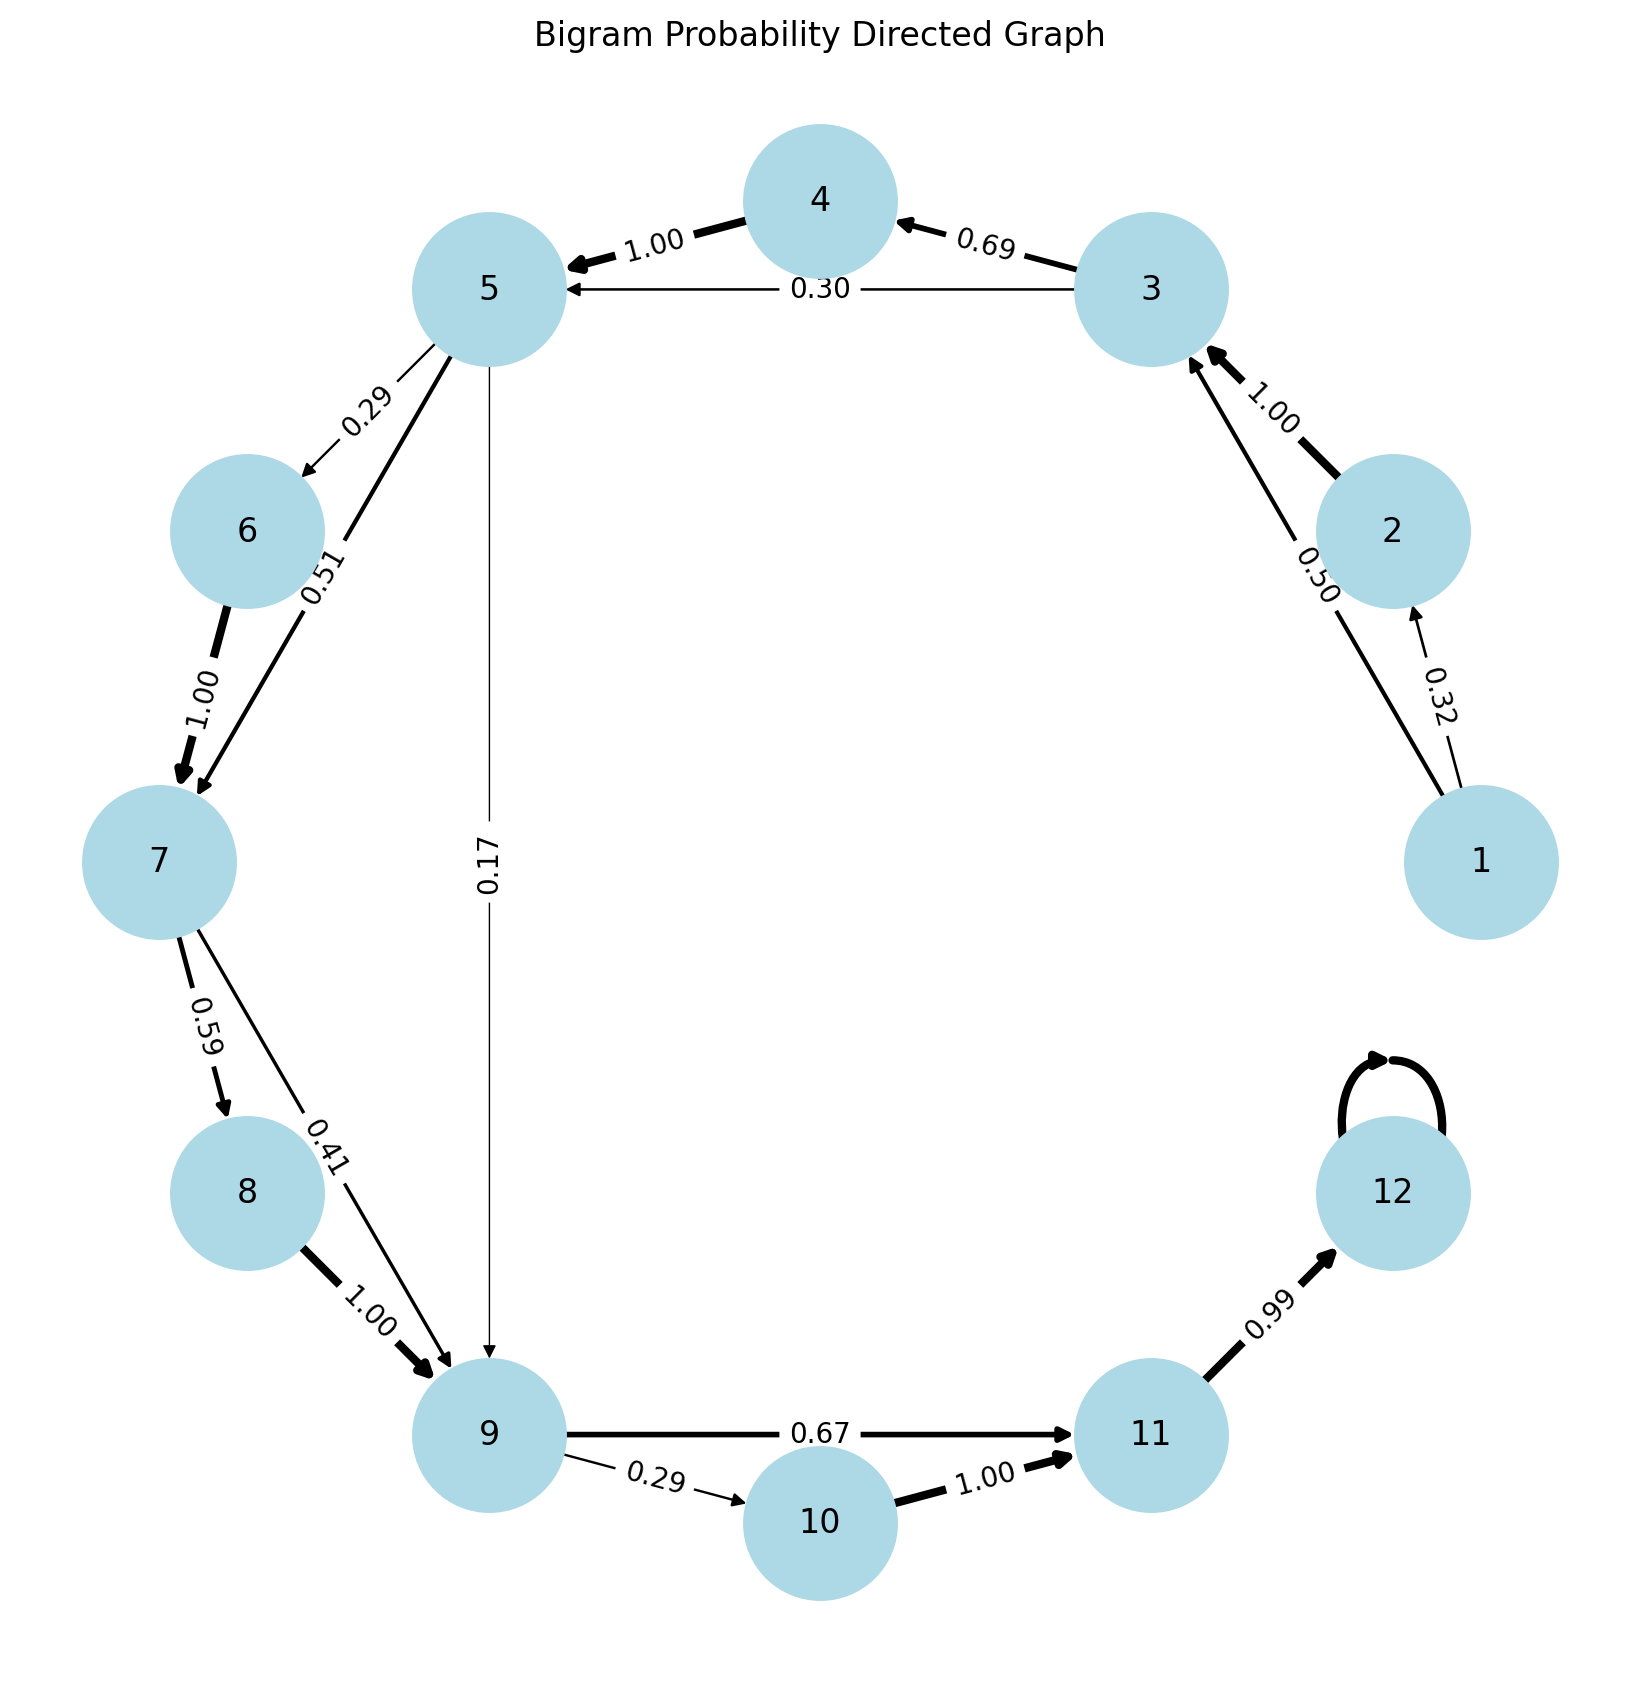

In [86]:
# use networkx to visualize the bigram matrix
note_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Create a directed graph from the bigram probabilities
G = nx.DiGraph()
for i, row in enumerate(bigram_prob):
    for j, prob in enumerate(row):
        if prob > 0.1:
            G.add_edge(note_labels[i], note_labels[j], weight=prob)

# Visualize the directed graph
plt.figure(figsize=(8,8))

# Create a circular layout with the correct order
pos = {note_labels[i]: (np.cos(2 * np.pi * i / 12), np.sin(2 * np.pi * i / 12)) for i in range(12)}

# Calculate edge widths based on their weights
edge_weights = nx.get_edge_attributes(G, 'weight')
edge_widths = [d * 3 for d in edge_weights.values()]

# Draw the graph with the calculated edge widths and custom positions
nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=3000, width=edge_widths)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d:.2f}" for (u, v), d in labels.items()})
plt.title('Bigram Probability Directed Graph')
plt.savefig('bigram_probability_directed_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [87]:
# the generation model

# use the current position to predict the next position
def predict_next_state(bigram_freq, current_state):
    """
    predict the next state based on the bigram frequency
    """
    # get the possible next states
    possible_next_states = [k[1] for k, v in bigram_freq.items() if k[0] == current_state]
    # get the frequency of each possible next state
    freq = [v for k, v in bigram_freq.items() if k[0] == current_state]
    # normalize the frequency
    freq = np.array(freq) / np.sum(freq)
    # predict the next state
    next_state = np.random.choice(possible_next_states, p=freq)
    return next_state

# get the cosine similarity between two bars
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# change the position list to a vector of length 12
def seq_to_vec(seq):
    return [1 if i+1 in seq else 0 for i in range(12)]

# given the start position, generate a bar
def generate_a_bar(bigram_freq, start_state):
    """
    generate a bar based on the bigram frequency
    """
    bar = [start_state]
    while True:
        next_state = predict_next_state(bigram_freq, bar[-1])
        bar.append(next_state)
        # stop when the next state is 12 or the bar is longer than 4 and the next state is larger than 9 at the probability of 0.6
        if next_state == 12 or (len(bar) >= 4 and next_state >= 9 and np.random.random() > 0.6):
            break
    return bar

# generate a sequence of bars
def generate_sequence(bigram_freq, start_state, num_bars, similarity_threshold=0.5):
    """
    generate a sequence based on the bigram frequency
    """
    sequence = [generate_a_bar(bigram_freq, start_state)]
    while len(sequence) < num_bars:
        bar = generate_a_bar(bigram_freq, start_state)
        # compare the similarity between the last bar in the sequence and the new bar
        vec1 = seq_to_vec(sequence[-1])
        vec2 = seq_to_vec(bar)
        similarity = cosine_similarity(vec1, vec2)

        if similarity >= similarity_threshold:
            sequence.append(bar)

    return sequence

In [88]:
def convert_to_duration(random_song_list):
    last = 4.0
    # read the list backwards
    random_song_list.reverse()
    # create a list with the duration of each note
    duration_list = []
    for bar in random_song_list:
        # reverse the inner list
        bar.reverse()
        for note in bar:
            duration_list.append(last - note)
            last = note
        last += 4.0
    # reverse the list again
    duration_list.reverse()
    return duration_list

In [89]:
def convert_to_stream(duration_list):
    # create an empty stream
    stream = music21.stream.Stream()
    # define the tempo as 3/4
    stream.append(music21.meter.TimeSignature('3/4'))
    # create note
    # assign random pitch (C4)
    # assign duration (quarter)
    # append the note into empty stream
    for duration in duration_list:
        note = music21.note.Note(pitch='C4', quarterLength=duration)
        stream.append(note)
    return stream

In [90]:
# generate a sequence based on the bigram frequency
sequence = generate_sequence(bigram_freq, start_state=1,num_bars=8,similarity_threshold=0.85)
print('Sequence represented by integers:\n',sequence)
new_sequence = map_beats_reverse(sequence)
print('Sequence represented by beats:\n',new_sequence)

Sequence represented by integers:
 [[1, 3, 4, 5, 6, 7, 8, 9], [1, 4, 5, 7, 8, 9], [1, 3, 4, 5, 7, 8, 9, 12], [1, 2, 3, 4, 5, 7, 8, 9, 11, 12], [1, 2, 3, 4, 5, 9, 11, 12], [1, 3, 4, 5, 9, 11], [1, 3, 4, 5, 6, 7, 9, 11], [1, 3, 4, 5, 7, 9]]
Sequence represented by beats:
 [[1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0], [1.0, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.75], [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5, 3.75], [1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 3.5, 3.75], [1.0, 1.5, 1.75, 2.0, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 3.0]]


In [91]:
stream_example = convert_to_stream(convert_to_duration(new_sequence))
# hear the midi file
stream_example.show('midi')

In [95]:
# generate 500 sequences based on the bigram frequency
# create an empty DataFrame with columns ['notes']
sequences = pd.DataFrame(columns=['notes'])
while len(sequences) < 500:
    try:
        sequence = generate_sequence(bigram_freq, start_state=1,num_bars=8,similarity_threshold=0.85)
        sequences.loc[len(sequences)] = [sequence]
    except:
        pass
# save
sequences.to_csv('markov_songs.csv',index=True)

**Part 4: Results, Metric, Evaluation**

**Goal:** evaluate the results of the random model, the original dataset, and our generation model, and compare the three. We will also highlight one good sample and one bad sample from our generation model.